# butchered ugly test version
# imdb movie review sentiment analysis with lstm

imports

In [2]:
%matplotlib inline

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM, CuDNNLSTM
from keras.datasets import imdb

from distutils.version import LooseVersion as LV
from keras import __version__
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

Using TensorFlow backend.


Using Keras version: 2.2.4 backend: tensorflow


## IMDB data set

load imdb dataset

50000 movie reviews

25000 training

25000 testing

half are postive (1) half are negative (0)

dataset is in preprocessed form and words have been replaced by integer

words indices start at 3, 1 to mark start of review, 2 represents out of vocab words, 0 used to pad

some weird security issue which requires TRUE pickle- no idea what this is but it is necessary

In [3]:
# number of most-frequent words to use
nb_words = 10000
# cut texts after this number of words
maxlen = 80

print('Loading data...')


#weird security thing below
old = np.load
np.load = lambda *a,**k: old(*a,**k,allow_pickle=True)

from keras.datasets import reuters
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=nb_words)

np.load = old
del(old)
#weird security thing above

print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print()

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
x_train: (25000,)
x_test: (25000,)

Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


the first movie review in the training set in integer form

this can be translated into words (in other notebook)

In [3]:
print("First review in the training set:\n", x_train[0], "length:", len(x_train[0]), "class:", y_train[0])

First review in the training set:
 [  15  256    4    2    7 3766    5  723   36   71   43  530  476   26
  400  317   46    7    4    2 1029   13  104   88    4  381   15  297
   98   32 2071   56   26  141    6  194 7486   18    4  226   22   21
  134  476   26  480    5  144   30 5535   18   51   36   28  224   92
   25  104    4  226   65   16   38 1334   88   12   16  283    5   16
 4472  113  103   32   15   16 5345   19  178   32] length: 80 class: 1


## Initialisation

make rnn:

input reviews

first layer is embedding layer- each word is taught a value and is connected

second layer is the dropout layer which always preceeds the lstm

third layer is lstm layer with 32 hidden units

dense layer next with sigmoid activation for classification

compile() model using *binary crossentropy* as the loss function and *RMSprop* as the optimizer

optimiser is not ideal- ADAM is preferred

get some error in colab- don't know why yet

In [4]:
# model parameters:
embedding_dims = 50
lstm_units = 32

print('Build model...')
model = Sequential()

model.add(Embedding(nb_words,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

model.add(LSTM(lstm_units))
# if running on a GPU:
#model.add(CuDNNLSTM(lstm_units))

# if multiple LSTM laters:
#model.add(LSTM(lstm_units, return_sequences=True))
#model.add(LSTM(lstm_units))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 50)            500000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 510,657
Trainable params: 510,657
Non-trainable params: 0
_________________________________________________________________
None


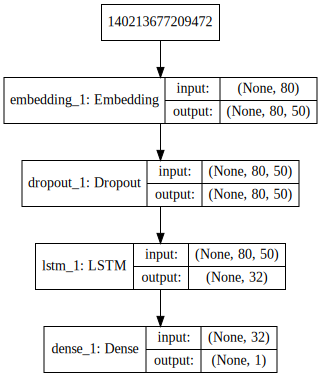

In [5]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Learning

train lstm on cpu

use `model.add(CuDNNLSTM(lstm_units))` instead of `model.add(LSTM(lstm_units))` to run on gpu

In [6]:
%%time
epochs = 5
validation_split = 0.2

history = model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 16s 788us/step - loss: 0.5158 - acc: 0.7449 - val_loss: 0.4521 - val_acc: 0.7898
Epoch 2/5
20000/20000 [==============================] - 14s 693us/step - loss: 0.3294 - acc: 0.8621 - val_loss: 0.3521 - val_acc: 0.8420
Epoch 3/5
20000/20000 [==============================] - 15s 734us/step - loss: 0.2766 - acc: 0.8885 - val_loss: 0.3765 - val_acc: 0.8308
Epoch 4/5
20000/20000 [==============================] - 15s 749us/step - loss: 0.2500 - acc: 0.8996 - val_loss: 0.3558 - val_acc: 0.8424
Epoch 5/5
20000/20000 [==============================] - 14s 713us/step - loss: 0.2298 - acc: 0.9095 - val_loss: 0.3885 - val_acc: 0.8438
CPU times: user 1min 37s, sys: 8.02 s, total: 1min 45s
Wall time: 1min 14s


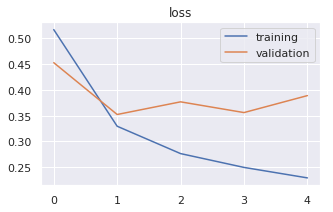

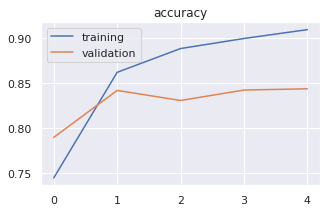

In [7]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'], label='training')
plt.plot(history.epoch,history.history['val_acc'], label='validation')
plt.title('accuracy')
plt.legend(loc='best');

## Accuracy

accuracy score

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

---
*To run in windows use [this](https://colab.research.google.com/github/dsanders3000/imdb/blob/master/uglytest.ipynb).*